# Advanced Lane Lines Detecting Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
# First les't import the need dependencies

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [3]:
# First step: prepare the 3D object points

objpoints = [] # undistorted real image points (3D points)
imgpoints = [] # 2D image points 
# we need to map the coordinates of the imgpoints to objpoints

# The object points (objpoints) will always be the same which are the known object points of the chessboard corners
# i.e. (0,0,0) for the first corner on the top left, and (8,5,0) for the last corner in the right bottom
# the z-coordinate is zero for all the points

# Now let's prepare the points of the objpoints 

objp = np.zeros((6*9, 3), np.float32)  # this creates a 54 x 3 matrix filled with zeros
#print("objp with zeros", objp)
#print("objp shape", objp.shape)

# now let's fill the x and y with the coordinates we want (i.e. (0,0,0), (1,0,0),....(8,0,0), (0,1,0), (1,1,0),...)  
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
#print("filled objp", objp)
#print("objp.shape", objp.shape)

error: no corners found in photo:  camera_cal/calibration1.jpg
error: no corners found in photo:  camera_cal/calibration5.jpg
error: no corners found in photo:  camera_cal/calibration4.jpg


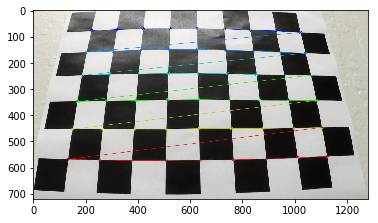

In [4]:
# Second step: get the corners of multiple distorted images
images = glob.glob('camera_cal/calibration*.jpg')
for fname in images:
    img = mpimg.imread(fname)
    # convert the image to gray to easily deal with it 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    plt.imshow(gray, cmap="gray")

    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:
        imgpoints.append(corners) # add the corners to the distorted image points
        objpoints.append(objp)    # the object points are always the same
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
    else:
        print("error: no corners found in photo: ", fname)

In [5]:
# Third step: Determine the camera matrix

# using the objectpoints we got from all the calibration images and the object points we constructed, we now:
# get the following 
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## 2. Apply a distortion correction to raw images.

array([[[209, 221, 227],
        [210, 222, 228],
        [210, 222, 228],
        ...,
        [205, 217, 221],
        [206, 218, 222],
        [206, 218, 222]],

       [[209, 221, 227],
        [209, 221, 227],
        [210, 222, 228],
        ...,
        [206, 218, 222],
        [205, 217, 221],
        [205, 217, 221]],

       [[209, 221, 227],
        [209, 221, 227],
        [209, 221, 227],
        ...,
        [206, 218, 222],
        [205, 217, 221],
        [206, 218, 222]],

       ...,

       [[184, 196, 201],
        [183, 195, 201],
        [183, 195, 201],
        ...,
        [177, 189, 191],
        [178, 190, 192],
        [177, 189, 191]],

       [[184, 196, 201],
        [183, 195, 201],
        [182, 194, 200],
        ...,
        [178, 190, 192],
        [179, 191, 193],
        [179, 191, 193]],

       [[184, 196, 202],
        [184, 196, 202],
        [183, 195, 201],
        ...,
        [179, 191, 193],
        [180, 192, 194],
        [178, 190, 192]]

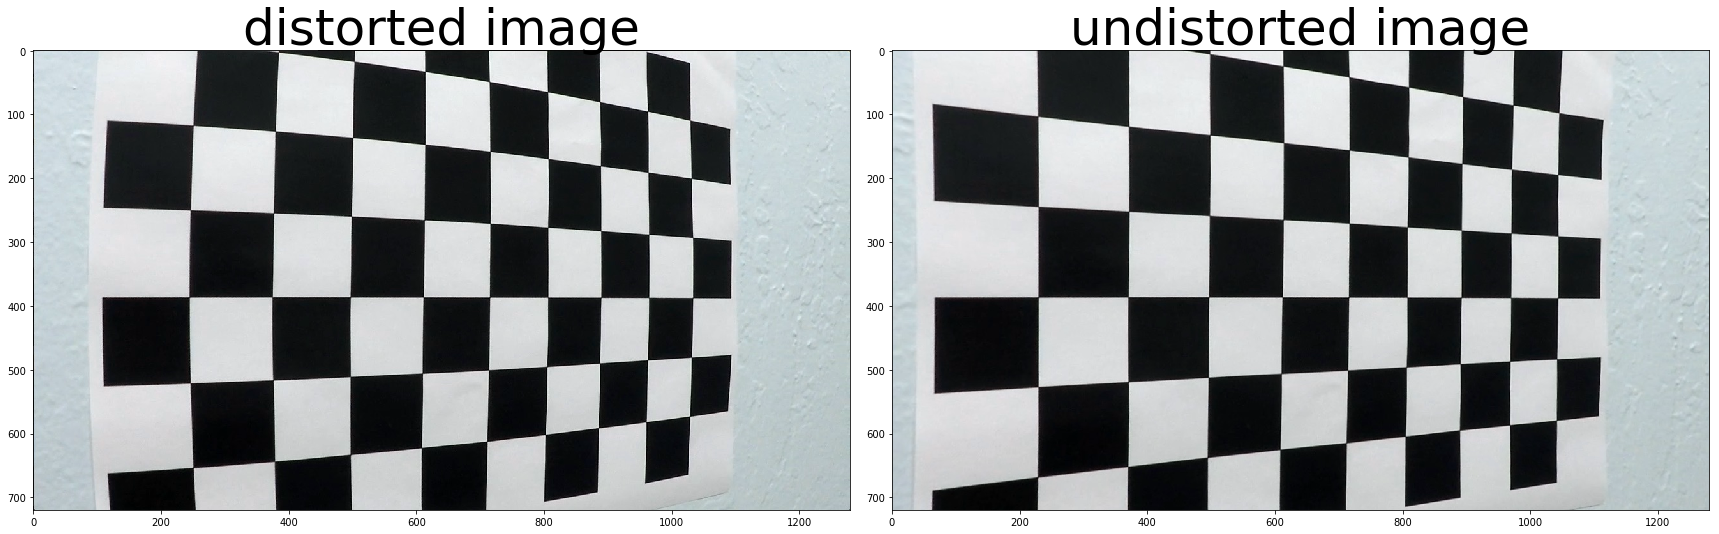

In [6]:
# Undistort the images using the camera matrix¶
# Now let's read a test image and try to undistort it
img = cv2.imread('camera_cal/calibration5.jpg')

def undistort_image(img, mtx, dist):
    # now undistor this image using the parameters determined in the previous steps
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img, cmap='gray')
    ax1.set_title('distorted image', fontsize=50)
    ax2.imshow(undist, cmap='gray')
    ax2.set_title('undistorted image', fontsize=50)
    return undist

undistort_image(img, mtx, dist)


## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

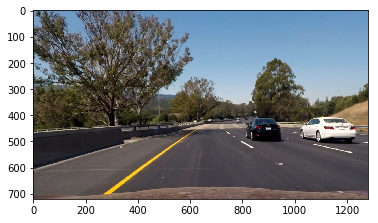

In [7]:
# Read in an image
im = mpimg.imread('test_images/test6.jpg')
# undistort the image
im = cv2.undistort(im, mtx, dist, None, mtx)
plt.imshow(im)

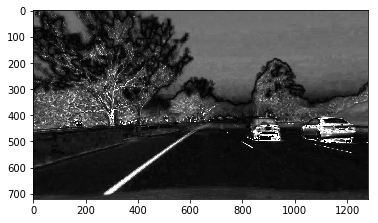

In [8]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(im, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
plt.imshow(s_channel, cmap='gray')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

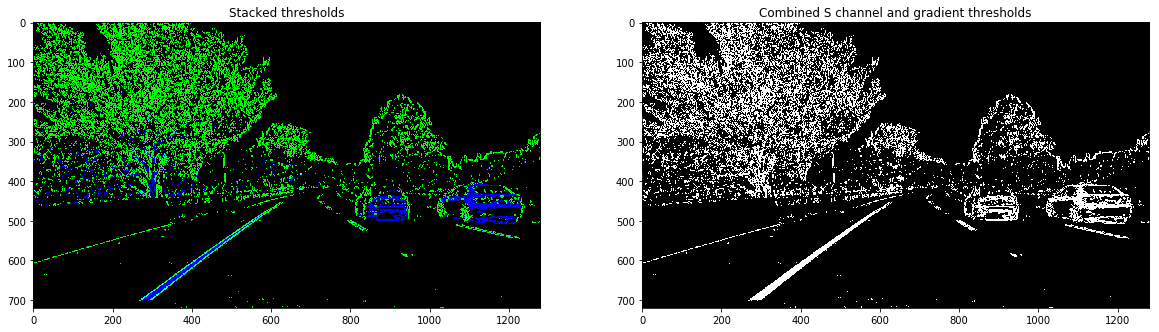

In [9]:
def thresholding(img, grad_to='gray', thresh=(20,100), s_thresh=(170,255)):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # grad_to = 'gray' # apply gradient to the gray image
    # grad_to = 's'    # apply gradient to the s-channel image
    if grad_to == 'gray':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    elif grad_to == 's':  
        sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x

    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(color_binary)

    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')   
    return combined_binary

# call the function thresholding()
thresholding(im, grad_to='gray', thresh=(20,100), s_thresh=(170,255))

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [10]:
#def change_prespective()

In [16]:
def change_prespective(img, trap_bottom_width, trap_top_width, trap_height_from_top, tap_bottom_trim, offset):
 
    '''
        1  2

     3         4
    '''
    src = np.float32([[img.shape[1]*(0.5 - trap_top_width/2), img.shape[0]*trap_height_from_top],
                      [img.shape[1]*(0.5 + trap_top_width/2), img.shape[0]*trap_height_from_top], 
                      [img.shape[1]*(0.5 - trap_bottom_width/2), img.shape[0]*tap_bottom_trim],
                      [img.shape[1]*(0.5 + trap_bottom_width/2), img.shape[0]*tap_bottom_trim]])
    dst = np.float32([[offset, 0],
                      [img.shape[1]-offset, 0], 
                      [offset, img.shape[0]], 
                      [img.shape[1]-offset,img.shape[0]]])

    img_size = (img.shape[1], img.shape[0])
    
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
     
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img, cmap='gray')
    ax1.set_title('image', fontsize=50)
    ax2.imshow(warped, cmap='gray')
    ax2.set_title('warped image', fontsize=50)
    
    return warped, M

# Test Pipeline on images

All the needed processing steps are defined as functions before and here we will be calling those functions:
- read_image()
- undistort_image()
- thresholding()
- change_prespective()
- detect_lane_pixels()
- get_curvature()
- wrap_lanes_on_image()
- display_info()

In [50]:
# read_image()
%matplotlib inline
def read_image(im_path):
    img = mpimg.imread(im_path)
    return img

im_path = 'test_images/test6.jpg'
img = read_image(im_path)
#plt.imshow(img)

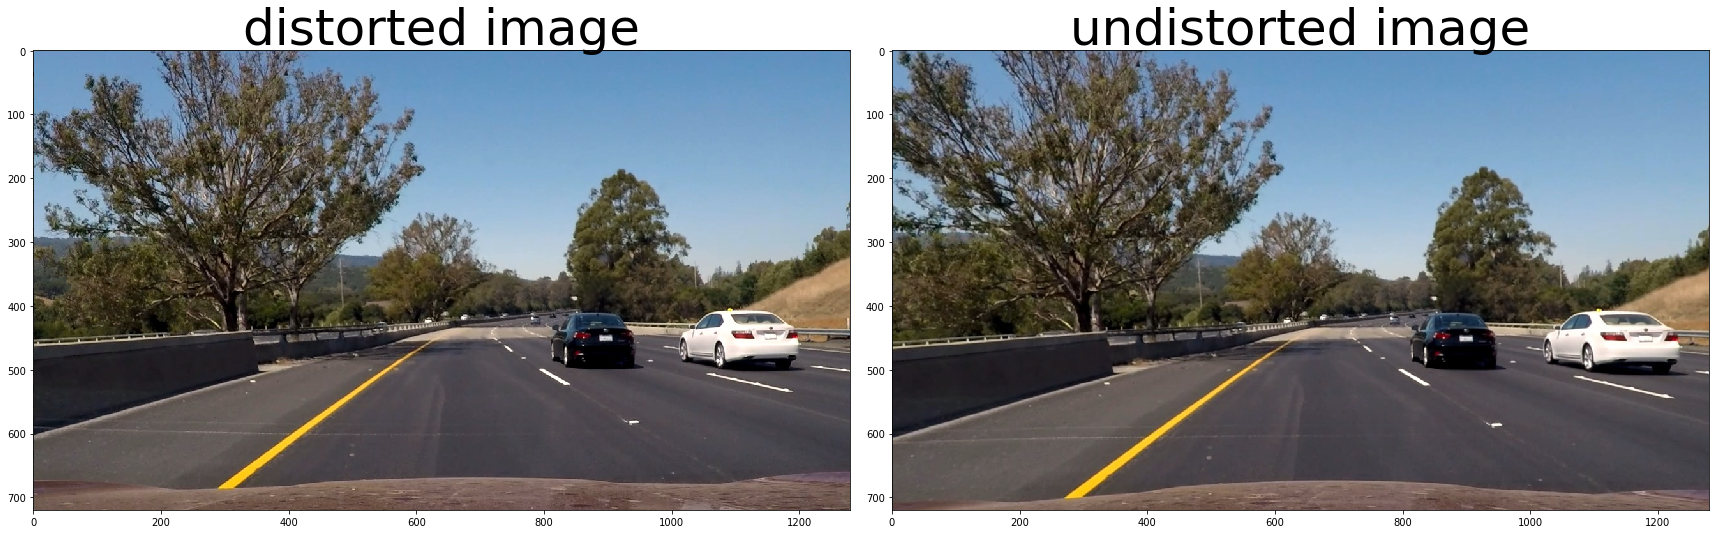

In [51]:
# undistort_image()
undistorted_image = undistort_image(img, mtx, dist)

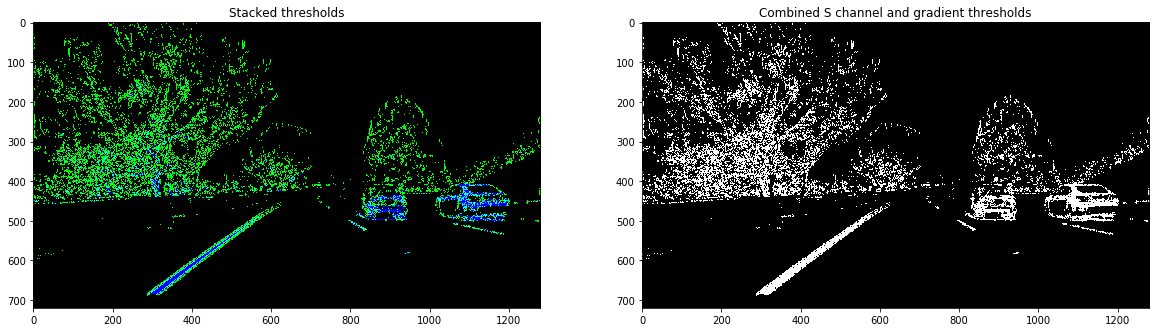

In [52]:
# thresholding()
combined_binary = thresholding(img, grad_to='s', thresh=(20,100), s_thresh=(170,255))

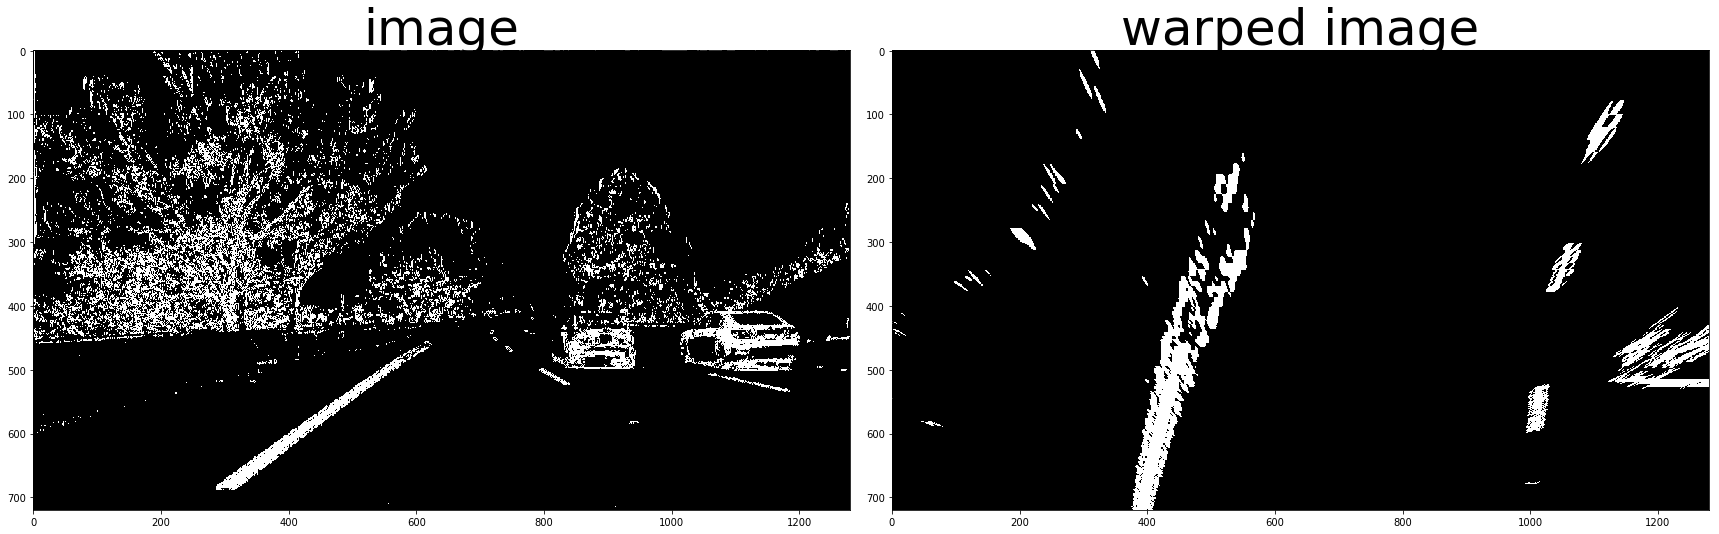

In [53]:
# change_prespective()
# values inspired by the Q & A video from Udacity Youtube channel with some adjustment
trap_bottom_width = 0.7
trap_top_width = 0.09
trap_height_from_top = 0.62 #(450/720 where 450 is end of right line and 720 is total height)
tap_bottom_trim = 0.9
offset = img.shape[1] * 0.2
top_down, perspective_M = change_prespective(combined_binary, 
                                             trap_bottom_width,
                                             trap_top_width,
                                             trap_height_from_top,
                                             tap_bottom_trim,
                                             offset)

[582.4 446.4]


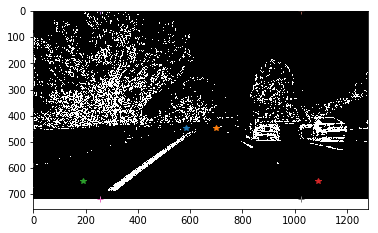

In [54]:
# plot the src and dst points on the image to get an idea how good they are
#%matplotlib qt
print(src[0])
plt.imshow(combined_binary, cmap='gray')
plt.plot(src[0,0],src[0,1], '*') 
plt.plot(src[1,0],src[1,1], '*') 
plt.plot(src[2,0],src[2,1], '*') 
plt.plot(src[3,0],src[3,1], '*') 
plt.plot(dst[0,0],dst[0,1], '+') 
plt.plot(dst[1,0],dst[1,1], '+') 
plt.plot(dst[2,0],dst[2,1], '+') 
plt.plot(dst[3,0],dst[3,1], '+') 
